# Machine Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|

## Table of Contents
- [Data Overview](#data-overview)
- [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
    
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [15]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

In [16]:
labeled_path = r"labeled"
unlabeled_path = r"unlabeled"

labeled_files = [os.path.join(labeled_path, file) for file in os.listdir(labeled_path)]
unlabeled_files = [os.path.join(unlabeled_path, file) for file in os.listdir(unlabeled_path)]

## Data Overview

In [17]:
labels_new = pd.read_csv('labels_new.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("labeled data")
display(labels_new.head(10))
print()
print("sample submission voor kaggle")
display(sample_submission.head(10))

labeled data


,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae
5,m00192.wav,classical
6,m00429.wav,hiphop
7,m00623.wav,reggae
8,m00002.wav,jazz
9,m00039.wav,reggae



sample submission voor kaggle


,filename,genre
0,metal.00032.wav,classical
1,pop.00023.wav,blues
2,classical.00076.wav,blues
3,classical.00021.wav,rock
4,metal.00052.wav,classical
5,classical.00040.wav,reggae
6,pop.00097.wav,hiphop
7,classical.00005.wav,pop
8,classical.00056.wav,pop
9,metal.00073.wav,classical


## Feature Engineering

In [18]:
def audio_features(files):
    features_list = []

    for file in files:
        # Check if it's an audio file (you can expand the condition for specific extensions)
        if file.endswith(('.wav', '.mp3', '.flac')):
            try:
                # Load the audio file
                y, sr = librosa.load(file, sr=None)  # Use original sampling rate

                # Extract features
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # MFCCs
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral contrast
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Spectral Bandwidth
                spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral Centroid
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)  # Roll-Off Frequency (85%)

                # Aggregate features (mean and standard deviation)
                feature_vector = {
                    'file_name': os.path.basename(file),
                    'mfccs_mean': np.mean(mfccs, axis=1).tolist(),
                    'mfccs_std': np.std(mfccs, axis=1).tolist(),
                    'chroma_mean': np.mean(chroma, axis=1).tolist(),
                    'spectral_contrast_mean': np.mean(spectral_contrast, axis=1).tolist(),
                    'spectral_bandwidth_mean': np.mean(spectral_bandwidth).tolist(),
                    'spectral_bandwidth_std': np.std(spectral_bandwidth).tolist(),
                    'spectral_centroid_mean': np.mean(spectral_centroid).tolist(),
                    'spectral_centroid_std': np.std(spectral_centroid).tolist(),
                    'rolloff_mean': np.mean(rolloff).tolist(),
                    'rolloff_std': np.std(rolloff).tolist(),
                }

                features_list.append(feature_vector)

            except Exception as e:
                print(f"Error processing {file}: {e}")
    return features_list


## Features uitleg 

- **Mel-frequency cepstral coefficients**: MFCC’s, of Mel-frequency Cepstral Coefficients, zijn een manier om geluid, zoals spraak, te analyseren en te vereenvoudigen zodat computers het kunnen begrijpen. Ze halen de belangrijkste eigenschappen van een stem of geluidssignaal naar voren, vergelijkbaar met een unieke handtekening. Dit helpt computers om verschillende woorden en stemmen te onderscheiden, bijvoorbeeld bij het omzetten van gesproken taal naar tekst in spraakherkenningssystemen. Deze feature bestaat dus uit meerdere coefficienten. Coëfficiënten 1 t/m 12 bevatten informatie over de variatie in het spectrum, zoals de toon. Verder werd er 2 soorten MFCC's waardes opgesteld en dat zijn de gemiddelde en standaard deviatie van de coefficienten. 

    **Het proces voor het berekenen van MFCC's**:
    -   Pre-processing:
        Het audiosignaal wordt gesegmenteerd in korte overlappende frames, zodat het stationair is (meestal 20-40 ms lang). 

    -   Fourier-transformatie:
        Elk frame wordt omgezet naar het frequentiedomein om het frequentiespectrum te verkrijgen.  

    -   Mel-filterbank toepassen:
        Een reeks filters (op de Mel-schaal) wordt toegepast om het frequentiespectrum te comprimeren tot een kleiner aantal frequentiebanden die meer aansluiten bij menselijke perceptie.  

    -   Logaritmische schaal:
        Het resultaat van de filterbank wordt logaritmisch geschaald om de manier waarop het menselijke oor veranderingen in intensiteit waarneemt na te bootsen.  

    -   Discrete Cosine Transform (DCT):
        DCT wordt toegepast om de log-Mel-spectrogramwaarden te decorreleren en een compacte representatie te creëren. Dit resulteert in de uiteindelijke MFCC's.
    https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/?ref=gcse_outind

- **Chroma**: Verwijst naar een representatie van muzikale toonhoogtes of notenharmonieën, onafhankelijk van de octaafhoogte. Het is een manier om de harmonische inhoud van een muziekstuk te analyseren en wordt vaak gebruikt in muziekanalysetoepassingen zoals genreclassificatie, melodieherkenning, en akkoordreconstructie. Chroma verdeelt de muzikale toonhoogtes in 12 klassen, overeenkomend met de 12 halve tonen in een octaaf (bijvoorbeeld C, C#, D, enzovoort).  

    Er zijn verschillende manieren om een geluidsopname om te zetten in een chromagram, een visuele weergave van de toonhoogteklassen in muziek. Dit kan bijvoorbeeld door frequenties om te zetten naar toonhoogtes met speciale wiskundige methoden, zoals de Fourier-transformatie, of door filtertechnieken te gebruiken.  
    Ook kun je de eigenschappen van een chromagram aanpassen door het geluid vóór of na de omzetting te bewerken. Hiermee kun je bijvoorbeeld de toon, timing of dynamiek veranderen. Hierdoor bestaan er veel soorten chromagrammen, die afhankelijk van het doel verschillend werken bij het analyseren van muziek. 
    https://en.wikipedia.org/wiki/Chroma_feature

    
- **Spectral contract**: Is een techniek die wordt gebruikt om de verschillen in energie (amplitude) tussen verschillende frequentiebanden binnen een geluidssignaal te analyseren. Het geeft informatie over de structuur van een geluid, zoals de verhouding tussen hoge en lage tonen, en helpt bij het identificeren van klanken. Het frequentiespectrum van een signaal wordt opgedeeld in meerdere frequentiebanden (bijvoorbeeld lage, midden en hoge tonen). Voor elke band wordt het contrast berekend als het verschil tussen de pieken (zoals harmonischen of andere sterke frequenties) en de dalen (gebieden met weinig energie, zoals stiltes of zwakke frequenties).  

    **Stap 1**: Voorbewerking van het audiosignaal

    We beginnen met een audiosignaal $x[n]$, dat wordt opgedeeld in kleine overlappende segmenten met behulp van een vensterfunctie (bijvoorbeeld een Hamming-venster). Elk segment wordt vervolgens verwerkt met de Short-Time Fourier Transform (STFT) om het frequentiespectrum te verkrijgen:

    $$
    x_w[k] = x[k] \cdot w[k]
    $$

    $$
    X(f) = \sum_{n=0}^{N-1} x_w[n] \cdot e^{-j 2 \pi f n / N}
    $$

    Hierbij is:
    - $x[k]$: Het originele signaal.
    - $w[k]$: De vensterfunctie.
    - $N$: De lengte van elk segment.
    - $X(f)$: De Fourier-transformatie, die de spectrale amplitude geeft bij frequentie $f$.



    **Stap 2**: Opdelen van het spectrum in frequentiebanden

    Het spectrum wordt ingedeeld in $B$ frequentiebanden. Elke band $b$ beslaat een bereik van frequenties $[f_{\text{min}}, f_{\text{max}}]$.

    Afhankelijk van de toepassing kunnen de banden lineair of logaritmisch worden ingedeeld:
    - **Lineair:** Elke band heeft dezelfde breedte.
    - **Logaritmisch:** Banden worden breder bij hogere frequenties, vergelijkbaar met hoe mensen geluid waarnemen.



    **Stap 3**: Energie binnen een band berekenen

    De energie in een frequentieband $b$ wordt berekend door de amplitudes in de band samen te voegen:

    $$
    E_b = \sum_{f=f_{\text{min}}}^{f_{\text{max}}} |X(f)|^2
    $$

    Hierbij is $|X(f)|^2$ de magnitude van de spectrale energie bij frequentie $f$.



    **Stap 4**: Pieken en dalen bepalen

    Voor elke frequentieband $b$ berekenen we:
    - **Piekenergie $P_b$:** Het gemiddelde van de hoogste $p\%$ waarden in de band.

    $$
    P_b = \frac{1}{|F_p|} \sum_{f \in F_p} |X(f)|
    $$

    - **Dalenergie $V_b$:** Het gemiddelde van de laagste $v\%$ waarden in de band.

    $$
    V_b = \frac{1}{|F_v|} \sum_{f \in F_v} |X(f)|
    $$

    Hierbij zijn $F_p$ en $F_v$ respectievelijk de sets van frequenties met de hoogste $p\%$ en laagste $v\%$ energie.



    **Stap 5**: Contrast berekenen

    Het **spectrale contrast** wordt berekend als het logaritmische verschil tussen de piek- en dalenergie in een band:

    $$
    C_b = \log_{10} \left( \frac{P_b}{V_b} \right)
    $$



    **Stap 6**: Combineer de contrastwaarden

    De spectrale contrastwaarden voor alle banden $b = 1, 2, \ldots, B$ worden samengevoegd tot een vector:

    $$
    \mathbf{C} = [C_1, C_2, \ldots, C_B]
    $$



    **Optioneel**: Tijdsgemiddelde

    Als het signaal over meerdere tijdframes wordt geanalyseerd, kan een gemiddelde waarde over de tijd worden berekend:

    $$
    \bar{C}_b = \frac{1}{T} \sum_{t=1}^T C_b(t)
    $$

    Hierbij is $T$ het aantal tijdframes.




In [19]:
labeled_fl = audio_features(labeled_files)
unlabeled_fl = audio_features(unlabeled_files)

In [20]:
labeled_df = pd.DataFrame(labeled_fl).set_index('file_name')
unlabeled_df = pd.DataFrame(unlabeled_fl).set_index('file_name')

In [21]:
unlabeled_df

,mfccs_mean,mfccs_std,chroma_mean,spectral_contrast_mean,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,
m00003.wav,"[-82.51111602783203, 97.34172058105469, -34.36...","[38.669281005859375, 17.976158142089844, 17.42...","[0.47129690647125244, 0.40974727272987366, 0.4...","[18.42324910196291, 14.811131697206996, 17.832...",2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,"[-1.9132977724075317, 72.6861572265625, -32.79...","[21.85912322998047, 17.475719451904297, 15.581...","[0.4568102955818176, 0.5573737621307373, 0.680...","[18.524160576331486, 13.818720668244472, 18.00...",2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,"[-287.60369873046875, 101.75817108154297, -35....","[70.5913314819336, 17.471935272216797, 14.6056...","[0.3978669047355652, 0.1438601016998291, 0.112...","[15.679685056568916, 18.681855999598262, 21.48...",1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351
m00043.wav,"[-120.14749145507812, 91.31721496582031, -38.8...","[44.28722381591797, 22.18126106262207, 23.4976...","[0.4205608665943146, 0.35271963477134705, 0.43...","[18.87152117386596, 14.35500698781533, 15.5682...",2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214
m00044.wav,"[-437.6044006347656, 170.93153381347656, 7.419...","[63.8968391418457, 28.720317840576172, 25.7035...","[0.12168776988983154, 0.10355798155069351, 0.3...","[14.75606253173177, 17.16370892840314, 22.3184...",900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182
...,...,...,...,...,...,...,...,...,...,...
m00971.wav,"[-246.1586456298828, 149.4286651611328, -41.98...","[76.47077941894531, 38.449031829833984, 15.516...","[0.3375800549983978, 0.2272903174161911, 0.499...","[17.927492352142526, 14.882813158957992, 19.21...",1588.217850,446.341219,1525.791709,459.815904,2733.184659,982.391092
m00973.wav,"[-8.573004722595215, 54.2957878112793, 20.9641...","[55.02655792236328, 23.15241813659668, 20.5675...","[0.3442322015762329, 0.4773417115211487, 0.461...","[20.139989902635932, 15.154152301920007, 19.01...",3295.063699,333.732126,3669.810467,938.109519,7876.372739,1289.897788
m00988.wav,"[-56.15306091308594, 36.44850158691406, 11.979...","[70.65717315673828, 33.994869232177734, 25.310...","[0.4564961791038513, 0.4181686043739319, 0.388...","[20.4345690226062, 17.928656849275942, 18.5909...",3361.641125,313.312735,3941.417696,1162.771630,8260.423162,1196.440796


In [22]:
# Final labeled DataFrame
class AudioFeatureExpander:
    def __init__(self, labeled_df):
        self.labeled_df = labeled_df
    def expand_features(self):
        # Define the features to expand and their respective lengths
        features_to_expand = {
            'mfccs_mean': 13,
            'mfccs_std': 13,
            'chroma_mean': 12,
            'spectral_contrast_mean': 7
        }
        expanded_features_df = pd.DataFrame(index=self.labeled_df.index)
        # Expand each feature
        for feature, length in features_to_expand.items():
            expanded_df = pd.DataFrame(self.labeled_df[feature].tolist(), index=self.labeled_df.index,
                                       columns=[f'{feature}_{i}' for i in range(length)])
            expanded_features_df = pd.concat([expanded_features_df, expanded_df], axis=1)
        # # Add the remaining features
        remaining_features = ['spectral_bandwidth_mean', 'spectral_bandwidth_std',
                              'spectral_centroid_mean', 'spectral_centroid_std',
                              'rolloff_mean', 'rolloff_std']
        expanded_features_df = pd.concat([expanded_features_df, self.labeled_df[remaining_features]], axis=1)
        return expanded_features_df

In [29]:
# Usage
unlabeled_expander = AudioFeatureExpander(unlabeled_df)
final_unlabeled_df = unlabeled_expander.expand_features()
display(final_unlabeled_df)

labeled_expander = AudioFeatureExpander(labeled_df)
final_labeled_df = labeled_expander.expand_features()
display(final_unlabeled_df)


,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-82.511116,97.341721,-34.367928,71.408501,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,38.669281,17.976158,17.420506,13.732415,9.274554,9.197666,9.216418,7.644602,7.794284,6.777957,7.380204,7.544622,7.064954,0.471297,0.409747,0.488772,0.442609,0.503924,0.427372,0.389844,0.410940,0.448522,0.488606,0.486308,0.662977,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,-1.913298,72.686157,-32.791992,63.605476,-18.556351,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954248,18.755697,-11.187991,21.859123,17.475719,15.581608,10.556849,8.347109,8.000425,8.903178,7.457137,7.373907,6.871805,6.721302,7.231080,6.247564,0.456810,0.557374,0.680655,0.526191,0.406365,0.417328,0.367432,0.334647,0.365308,0.423689,0.311572,0.326611,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,-287.603699,101.758171,-35.345406,41.280159,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,-8.788416,-0.053095,-13.757536,70.591331,17.471935,14.605653,7.484632,11.334907,7.317162,10.026291,7.892459,8.673855,9.159690,12.261617,8.443221,11.332116,0.397867,0.143860,0.112334,0.102700,0.387866,0.583642,0.278688,0.283264,0.192714,0.517787,0.310177,0.168636,15.679685,18.681856,21.483555,23.963961,24.473956,23.647332,34.825406,1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351
m00043.wav,-120.147491,91.317215,-38.845890,75.008400,-3.813260,22.665588,-8.119440,23.654900,-14.630774,13.370975,-9.403305,13.706296,-9.315235,44.287224,22.181261,23.497639,14.564473,10.189630,10.347978,9.210694,8.198386,6.618116,8.076797,6.721008,5.650340,6.336876,0.420561,0.352720,0.438729,0.588503,0.809106,0.540158,0.336136,0.368313,0.400302,0.380119,0.425498,0.526869,18.871521,14.355007,15.568276,14.744588,16.072624,19.146556,39.286679,2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214
m00044.wav,-437.604401,170.931534,7.419581,-3.083473,0.789382,-11.128749,-12.522781,-6.907836,-5.858702,-8.461237,-8.481487,-8.339388,-7.378574,63.896839,28.720318,25.703560,11.270920,11.725129,11.461706,11.061062,10.545693,13.923300,11.246155,12.618073,14.727922,11.223578,0.121688,0.103558,0.303259,0.355438,0.127611,0.195966,0.140674,0.182006,0.287204,0.227969,0.408830,0.159130,14.756063,17.163709,22.318450,24.297561,24.119580,21.639522,17.475062,900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-246.158646,149.428665,-41.988865,11.606256,-10.289648,-4.019358,-7.136855,-10.135562,-9.420322,-7.171843,-3.158368,-5.640657,-2.586296,76.470779,38.449032,15.516282,9.866004,7.818055,7.556600,6.768150,8.246713,7.970280,7.855545,8.819655,7.837424,9.696887,0.337580,0.227290,0.499260,0.296814,0.362897,0.349061,0.208238,0.392273,0.218967,0.32106

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-82.511116,97.341721,-34.367928,71.408501,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,38.669281,17.976158,17.420506,13.732415,9.274554,9.197666,9.216418,7.644602,7.794284,6.777957,7.380204,7.544622,7.064954,0.471297,0.409747,0.488772,0.442609,0.503924,0.427372,0.389844,0.410940,0.448522,0.488606,0.486308,0.662977,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,-1.913298,72.686157,-32.791992,63.605476,-18.556351,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954248,18.755697,-11.187991,21.859123,17.475719,15.581608,10.556849,8.347109,8.000425,8.903178,7.457137,7.373907,6.871805,6.721302,7.231080,6.247564,0.456810,0.557374,0.680655,0.526191,0.406365,0.417328,0.367432,0.334647,0.365308,0.423689,0.311572,0.326611,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,-287.603699,101.758171,-35.345406,41.280159,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,-8.788416,-0.053095,-13.757536,70.591331,17.471935,14.605653,7.484632,11.334907,7.317162,10.026291,7.892459,8.673855,9.159690,12.261617,8.443221,11.332116,0.397867,0.143860,0.112334,0.102700,0.387866,0.583642,0.278688,0.283264,0.192714,0.517787,0.310177,0.168636,15.679685,18.681856,21.483555,23.963961,24.473956,23.647332,34.825406,1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351
m00043.wav,-120.147491,91.317215,-38.845890,75.008400,-3.813260,22.665588,-8.119440,23.654900,-14.630774,13.370975,-9.403305,13.706296,-9.315235,44.287224,22.181261,23.497639,14.564473,10.189630,10.347978,9.210694,8.198386,6.618116,8.076797,6.721008,5.650340,6.336876,0.420561,0.352720,0.438729,0.588503,0.809106,0.540158,0.336136,0.368313,0.400302,0.380119,0.425498,0.526869,18.871521,14.355007,15.568276,14.744588,16.072624,19.146556,39.286679,2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214
m00044.wav,-437.604401,170.931534,7.419581,-3.083473,0.789382,-11.128749,-12.522781,-6.907836,-5.858702,-8.461237,-8.481487,-8.339388,-7.378574,63.896839,28.720318,25.703560,11.270920,11.725129,11.461706,11.061062,10.545693,13.923300,11.246155,12.618073,14.727922,11.223578,0.121688,0.103558,0.303259,0.355438,0.127611,0.195966,0.140674,0.182006,0.287204,0.227969,0.408830,0.159130,14.756063,17.163709,22.318450,24.297561,24.119580,21.639522,17.475062,900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-246.158646,149.428665,-41.988865,11.606256,-10.289648,-4.019358,-7.136855,-10.135562,-9.420322,-7.171843,-3.158368,-5.640657,-2.586296,76.470779,38.449032,15.516282,9.866004,7.818055,7.556600,6.768150,8.246713,7.970280,7.855545,8.819655,7.837424,9.696887,0.337580,0.227290,0.499260,0.296814,0.362897,0.349061,0.208238,0.392273,0.218967,0.32106

In [26]:
numeric_features = final_unlabeled_df.select_dtypes(include=[np.number])

In [27]:
sns.set(style="darkgrid")

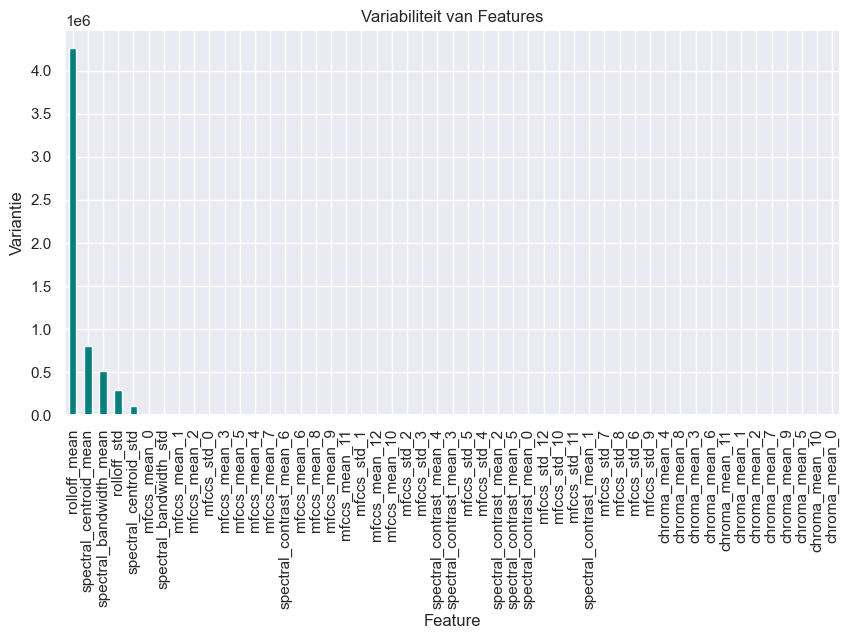

In [28]:
# Variabiliteit berekenen
feature_variability = numeric_features.var().sort_values(ascending=False)

# Plot de variabiliteit
plt.figure(figsize=(10, 5))
feature_variability.plot(kind='bar', color='teal')
plt.title('Variabiliteit van Features')
plt.ylabel('Variantie')
plt.xlabel('Feature')
plt.show()

## Modeling

In [30]:
labeled_data = final_labeled_df
unlabeled_data = final_unlabeled_df

In [31]:
def plot_elbow(data, r=range(1,11)):
    wcss = []  # Within-cluster sum of squares
    for k in r:  # Try k values from 1 to 10
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(r, wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

def plot_dendrogram(lm):
    plt.figure(figsize=(10, 6))
    dendrogram(
        lm,
        leaf_rotation=90,  # Rotates x-axis labels
        leaf_font_size=10,  # Font size for x-axis labels
        color_threshold=1.5,  # Set the color threshold for clusters
    )
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

def plot_tsne(data, x='t-SNE1', y='t-SNE2'):
    plt.figure(figsize=(8, 6))
    plt.scatter(data['t-SNE1'], data['t-SNE2'], s=50, c='blue', alpha=0.7)
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


### K-Means Clustering

K-means is een bekend algoritme dat wordt gebruikt voor clustering, een methode binnen unsupervised machine learning. Dit betekent dat het helpt om gegevens zonder labels in groepen te verdelen op basis van hun eigenschappen. Het doel van K-means is om een dataset op te splitsen in 'k' groepen (clusters). Elk datapunt wordt toegewezen aan de groep waarvan het gemiddelde, het zogenaamde centroid, het dichtstbij ligt.

[(Wikipedia contributors, 2024)](https://en.wikipedia.org/wiki/K-means_clustering)


### Afstandsmaatstaven in K-means

Om te bepalen welk gegevenspunt bij welk cluster hoort, gebruikt K-means een afstandsmaat. Meestal wordt de Euclidische afstand gebruikt. Soms is de Manhattan-afstand beter geschikt, afhankelijk van de dataset en het doel.

Euclidische afstand:
De Euclidische afstand meet de rechte lijn tussen twee punten in een n-dimensionale ruimte. Het wordt berekend met:

$$
d_{\text{euclid}}(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$

Manhattan-afstand:
De Manhattan-afstand berekent de totale som van de absolute verschillen tussen de coördinaten van twee punten. Het wordt berekend met:

$$
d_{\text{manhattan}}(x, y) = \sum_{i=1}^{n} |x_i - y_i|
$$

[(Sahani, 2024)](https://medium.com/analytics-vidhya/euclidean-and-manhattan-distance-metrics-in-machine-learning-a5942a8c9f2f)





#### Werking van het K-means algoritme

Het K-means algoritme werkt in verschillende stappen en kan worden aangepast met verschillende manieren om afstanden te meten. Eerst worden 'k' willekeurige startpunten, ook wel centroids genoemd, gekozen uit de dataset. Daarna wordt voor elk gegevenspunt de afstand tot de centroids berekend. Hiervoor kan de Euclidische afstando f de Manhattan-afstand worden gebruikt. Elk punt wordt toegewezen aan het dichtstbijzijnde centroid.

Vervolgens worden de centroids bijgewerkt. Bij de Euclidische afstand wordt het nieuwe centroid berekend als het gemiddelde van alle punten in het cluster. Bij de Manhattan-afstand wordt de mediaan van de punten gebruikt in plaats van het gemiddelde. Dit wordt K-medians genoemd. De stappen van toewijzen en bijwerken worden herhaald totdat de centroids niet meer veranderen of het maximale aantal iteraties is bereikt.



[(GeeksforGeeks, 2024)](https://www.geeksforgeeks.org/k-means-clustering-introduction/)

#### Wiskundige formule

Bij K-means wordt de totale binnen-clustervariatie geminimaliseerd. Dit wordt formeel uitgedrukt als:

$$
\sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Waarbij:
- *k*: het aantal clusters.  
- *C<sub>i</sub>*: het i-de cluster.  
- *x*: een gegevenspunt in cluster *C<sub>i</sub>*.  
- *μ<sub>i</sub>*: het centroid van cluster *C<sub>i</sub>*.  
- *‖x − μ<sub>i</sub>‖²*: de kwadraatafstand tussen een punt en het centroid.  

**Inertia in K-means**

Inertia is een maatstaf die de som meet van de kwadraatafstanden van alle gegevenspunten tot hun dichtstbijzijnde centroid. Het wordt gebruikt om de compactheid van clusters te beoordelen. Een lagere inertia betekent dat de clustering beter is, omdat de gegevenspunten dichter bij hun centroid liggen.

Inertia speelt een belangrijke rol in het K-means-algoritme. Het wordt gebruikt om de clustering te optimaliseren door de positie van de centroids herhaaldelijk aan te passen totdat de inertia minimaal is. Daarnaast helpt inertia bij het bepalen van het optimale aantal clusters (k), bijvoorbeeld met de Elbow-methode.

[(Ogbeide, 2024)](https://medium.com/@jeffzyme/understanding-inertia-distortion-and-silhouette-scores-and-their-differences-key-metrics-for-458fe28ce2aa)


#### Optimalisatie van k

Het bepalen van k (het aantal clusters) is een belangrijk onderdeel van K-means. Er zijn twee veelgebruikte methoden om dit te doen:

- **Elbow-methode:** Hierbij wordt gekeken naar de som van de kwadraatafstanden binnen clusters voor verschillende waarden van k. Het "knikpunt" in de grafiek geeft aan wat het optimale aantal clusters is.

- **Silhouette-score:** Deze methode beoordeelt hoe goed een punt in zijn eigen cluster past, vergeleken met het dichtstbijzijnde andere cluster. Hoe hoger de score, hoe beter de clustering.


[(Mahendru, 2025)](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)




## Bronnen:

- Wikipedia contributors. (2024, 27 november). K-means clustering. https://en.wikipedia.org/wiki/K-means_clustering

- Sahani, G. R. (2024, 15 januari). Euclidean and Manhattan distance metrics in Machine Learning. Medium. https://medium.com/analytics-vidhya/euclidean-and-manhattan-distance-metrics-in-machine-learning-a5942a8c9f2f

- GeeksforGeeks. (2024, 29 augustus). K means Clustering Introduction. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-clustering-introduction/

- Ogbeide, J. (2024, 14 november). “Understanding Inertia, Distortion, and Silhouette Scores and their differences: Key Metrics for Effective Clustering Analysis”. Medium. https://medium.com/@jeffzyme/understanding-inertia-distortion-and-silhouette-scores-and-their-differences-key-metrics-for-458fe28ce2aa

- Mahendru, K. (2025, 3 januari). How to Determine the Optimal K for K-Means? - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

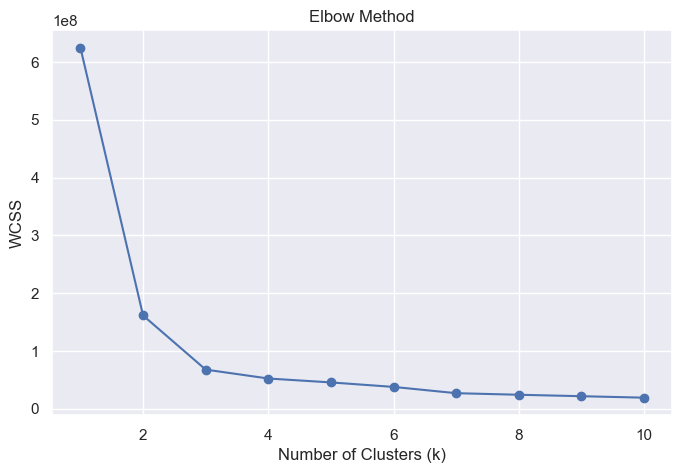

In [33]:
plot_elbow(unlabeled_data, r=range(1,11))

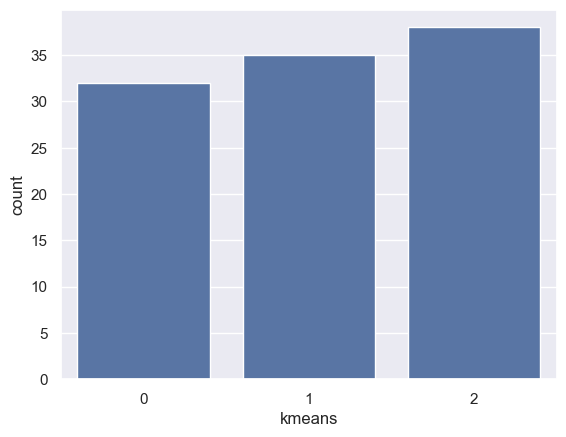

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(unlabeled_data)
labels = kmeans.predict(unlabeled_data)
unlabeled_data['kmeans'] = labels
sns.countplot(data=unlabeled_data, x=unlabeled_data['kmeans'])
plt.show()

### Hierarchical Clustering

Hierarchical clustering is een techniek binnen unsupervised machine learning die gegevenspunten groepeert op basis van hoe vergelijkbaar ze zijn. Het resultaat is een hiërarchie van clusters, die meestal wordt weergegeven als een dendrogram. Dit toont hoe de clusters op verschillende niveaus met elkaar verbonden zijn. 
Soorten Hierarchical Clustering:

1. **Agglomeratieve clustering:** Bij deze methode begint elk gegevenspunt als een apart cluster. Vervolgens worden de meest vergelijkbare clusters stap voor stap samengevoegd, totdat uiteindelijk alle punten in één groot cluster zitten.

2. **Divisive clustering:** Hierbij begint alle data in één groot cluster. Dit cluster wordt vervolgens herhaaldelijk opgesplitst in kleinere clusters op basis van verschillen, totdat elk gegevenspunt een eigen cluster vormt.

[(Uniyal, 2024)](https://www.appliedaicourse.com/blog/hierarchical-clustering-in-machine-learning/)
[(Gupta, 2022)](https://www.scaler.com/topics/machine-learning/hierarchical-clustering/)

#### Hoe Agglomeratieve Hierarchical Clustering Werkt

Bij agglomeratieve Hierarchical clustering begint elk gegevenspunt als een eigen cluster. In elke iteratie worden de twee dichtstbijzijnde clusters samengevoegd, waarbij een vooraf gekozen afstandsmaat wordt gebruikt om de afstand tussen clusters te berekenen. Het proces gaat door totdat er nog maar één cluster overblijft of het gewenste aantal clusters is bereikt.

**Afstandsmaatstaven:**

Er worden verschillende methoden gebruikt om de afstand tussen clusters te berekenen:

- **Single linkage:** De afstand tussen de twee dichtstbijzijnde punten in verschillende clusters.
- **Complete linkage:** De afstand tussen de twee verste punten in verschillende clusters.
- **Average linkage:** De gemiddelde afstand tussen alle punten in twee verschillende clusters.
- **Ward’s methode:** Minimaliseert de variantie tussen clusters en wordt vaak gebruikt omdat het gelijkmatige clusters van vergelijkbare grootte creëert.

**Dendrogram in Hierarchical Clustering**

Een dendrogram is een boomvormig diagram dat laat zien hoe clusters worden gevormd in hierarchische clustering. Elk blad in het diagram stelt één gegevenspunt voor. Naarmate je omhoog kijkt in het diagram, zie je hoe clusters samenkomen. De hoogte waarop twee clusters worden samengevoegd geeft aan hoe verschillend of ver ze van elkaar zijn. Dit maakt het makkelijker om te begrijpen hoe de gegevens en clusters met elkaar verbonden zijn in elke stap van het proces.



**Belangrijke Verschillen tussen Divisieve Clustering en Agglomeratieve Clustering**

Divisieve clustering is complexer omdat het bij elke stap alle mogelijke manieren moet overwegen om een cluster op te splitsen, wat meer rekenkracht vereist. Deze methode is vooral geschikt voor datasets met een natuurlijke top-down hiërarchie, zoals organisatiestructuren of stambomen. Hoewel agglomeratieve clustering vaker wordt toegepast, biedt divisieve clustering waardevolle inzichten in situaties waarin een hiërarchisch overzicht van boven naar beneden belangrijk is.

[(Uniyal, 2024)](https://www.appliedaicourse.com/blog/hierarchical-clustering-in-machine-learning/)



- Uniyal, M. (2024, 18 oktober). Hierarchical clustering in machine learning. Applied AI Blog. https://www.appliedaicourse.com/blog/hierarchical-clustering-in-machine-learning/

- Gupta, B. (2022, 16 november). Hierarchical clustering in machine learning- Scaler topics. Scaler Topics. https://www.scaler.com/topics/machine-learning/hierarchical-clustering/







In [36]:
# Compute the linkage matrix
linkage_matrix = linkage(unlabeled_data, method='ward')

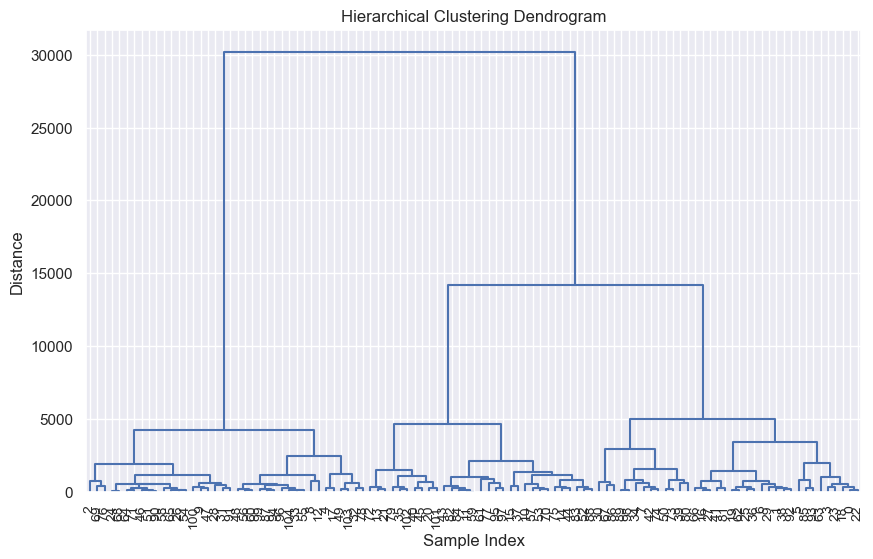

In [37]:
plot_dendrogram(linkage_matrix)

In [39]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
unlabeled_data['HC'] = cluster_labels
display(unlabeled_data)

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std,kmeans,HC
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-82.511116,97.341721,-34.367928,71.408501,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,38.669281,17.976158,17.420506,13.732415,9.274554,9.197666,9.216418,7.644602,7.794284,6.777957,7.380204,7.544622,7.064954,0.471297,0.409747,0.488772,0.442609,0.503924,0.427372,0.389844,0.410940,0.448522,0.488606,0.486308,0.662977,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300,1,3
m00012.wav,-1.913298,72.686157,-32.791992,63.605476,-18.556351,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954248,18.755697,-11.187991,21.859123,17.475719,15.581608,10.556849,8.347109,8.000425,8.903178,7.457137,7.373907,6.871805,6.721302,7.231080,6.247564,0.456810,0.557374,0.680655,0.526191,0.406365,0.417328,0.367432,0.334647,0.365308,0.423689,0.311572,0.326611,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095,1,3
m00013.wav,-287.603699,101.758171,-35.345406,41.280159,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,-8.788416,-0.053095,-13.757536,70.591331,17.471935,14.605653,7.484632,11.334907,7.317162,10.026291,7.892459,8.673855,9.159690,12.261617,8.443221,11.332116,0.397867,0.143860,0.112334,0.102700,0.387866,0.583642,0.278688,0.283264,0.192714,0.517787,0.310177,0.168636,15.679685,18.681856,21.483555,23.963961,24.473956,23.647332,34.825406,1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351,2,1
m00043.wav,-120.147491,91.317215,-38.845890,75.008400,-3.813260,22.665588,-8.119440,23.654900,-14.630774,13.370975,-9.403305,13.706296,-9.315235,44.287224,22.181261,23.497639,14.564473,10.189630,10.347978,9.210694,8.198386,6.618116,8.076797,6.721008,5.650340,6.336876,0.420561,0.352720,0.438729,0.588503,0.809106,0.540158,0.336136,0.368313,0.400302,0.380119,0.425498,0.526869,18.871521,14.355007,15.568276,14.744588,16.072624,19.146556,39.286679,2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214,1,3
m00044.wav,-437.604401,170.931534,7.419581,-3.083473,0.789382,-11.128749,-12.522781,-6.907836,-5.858702,-8.461237,-8.481487,-8.339388,-7.378574,63.896839,28.720318,25.703560,11.270920,11.725129,11.461706,11.061062,10.545693,13.923300,11.246155,12.618073,14.727922,11.223578,0.121688,0.103558,0.303259,0.355438,0.127611,0.195966,0.140674,0.182006,0.287204,0.227969,0.408830,0.159130,14.756063,17.163709,22.318450,24.297561,24.119580,21.639522,17.475062,900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-246.158646,149.428665,-41.988865,11.606256,-10.289648,-4.019358,-7.136855,-10.135562,-9.420322,-7.171843,-3.158368,-5.640657,-2.586296,76.470779,38.449032,15.516282,9.866004,7.818055,7.556600,6.768150,8.246713,7.970280,7.855545,8.819655,7.837424,9.696887,0.337580,0.227290,0.499260,0.296814,0.362897,0.3

### T-SNE

In [40]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(unlabeled_data)

# Add t-SNE results to the DataFrame
unlabeled_data['t-SNE1'] = tsne_results[:, 0]
unlabeled_data['t-SNE2'] = tsne_results[:, 1]

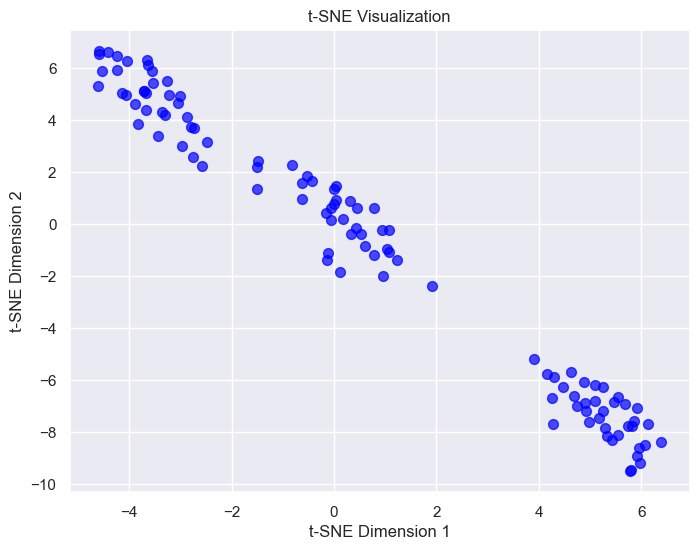

In [41]:
plot_tsne(unlabeled_data, x='t-SNE1', y='t-SNE2')

### Principal Component Analysis (PCA)

In [42]:
pca = PCA(n_components=2)  # Reduce to 2 components
pca_results = pca.fit_transform(unlabeled_data)

# Add PCA results to DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

Explained Variance Ratio: [0.96204317 0.03183654]


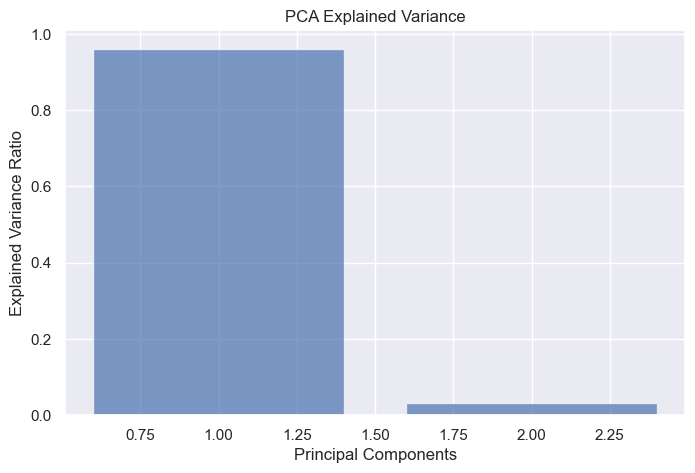

In [43]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

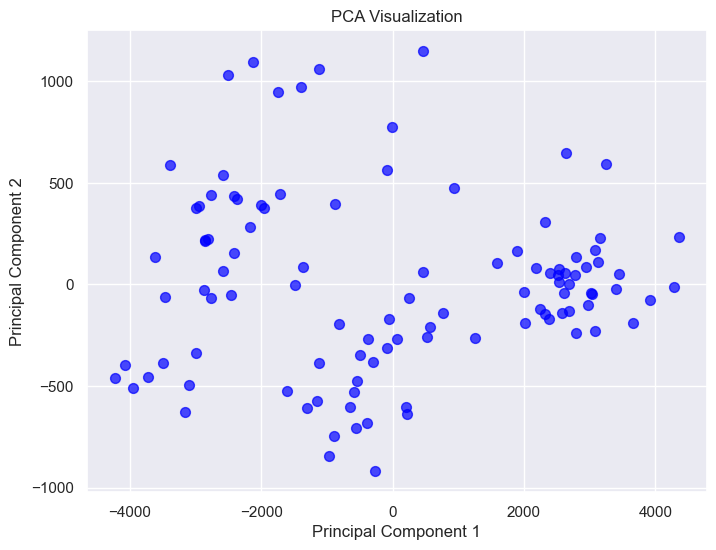

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', s=50, alpha=0.7)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

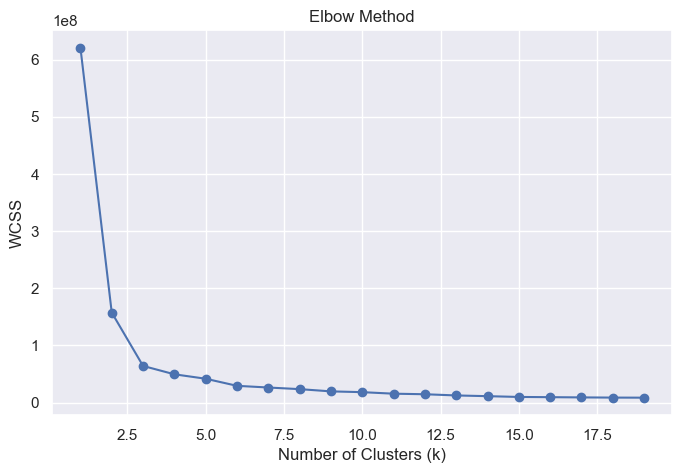

In [45]:
plot_elbow(pca_df, r=range(1,20))

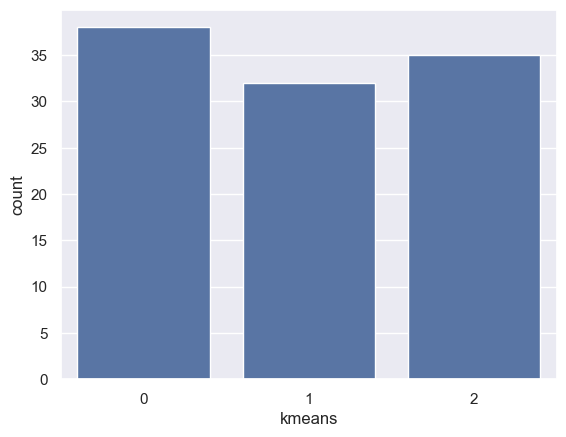

In [51]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca_df)
labels = kmeans.predict(pca_df)
pca_df['kmeans'] = labels
sns.countplot(data=pca_df, x=pca_df['kmeans'])
plt.show()

In [52]:
# Compute the linkage matrix
linkage_matrix = linkage(pca_df, method='ward')

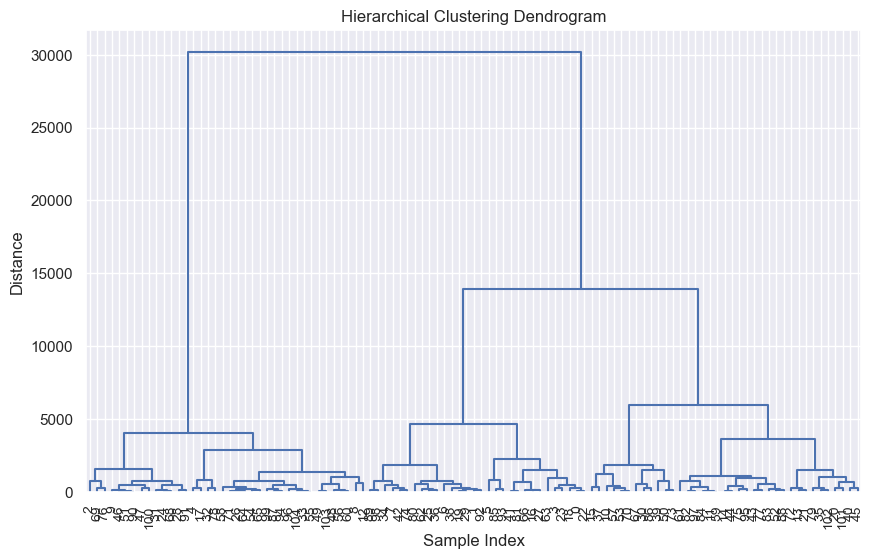

In [53]:
plot_dendrogram(linkage_matrix)

In [54]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
pca_df['HC'] = cluster_labels
print(pca_df)

             PC1         PC2  kmeans  HC
0     524.593561 -257.058846       2   2
1    -650.553623 -601.301360       2   2
2    1251.458535 -263.154041       0   1
3     251.345479  -65.148633       2   2
4    4289.503185  -10.190185       0   1
..           ...         ...     ...  ..
100  2321.579084  308.254741       0   1
101 -3493.868661 -387.980520       1   3
102 -3950.815219 -508.830640       1   3
103  3443.727776   53.580848       0   1
104  2968.047584  -98.636417       0   1

[105 rows x 4 columns]


In [55]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(pca_df)

# Add t-SNE results to the DataFrame
pca_df['t-SNE1'] = tsne_results[:, 0]
pca_df['t-SNE2'] = tsne_results[:, 1]

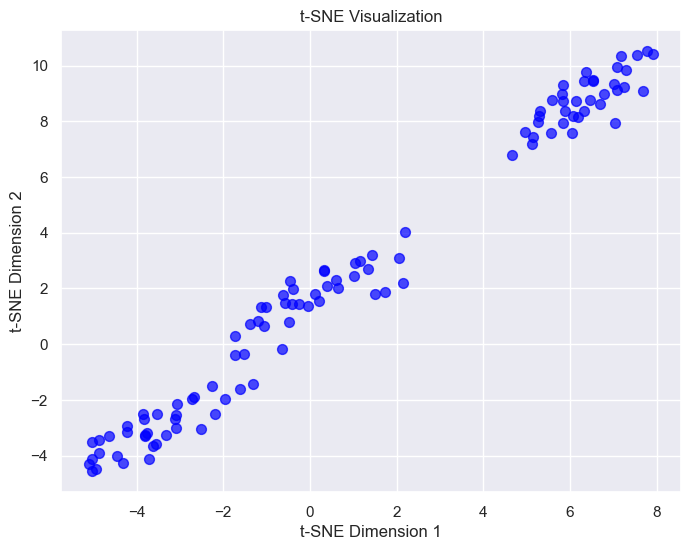

In [56]:
plot_tsne(pca_df, x='t-SNE1', y='t-SNE2')

### Non-Negative Matrix Factorization (NMF)

In [58]:
data_non_negative = np.abs(unlabeled_data.values)  # Ensure all values are non-negative

# Apply NMF
nmf = NMF(n_components=2, random_state=42, max_iter=1000)
nmf_features = nmf.fit_transform(data_non_negative)

# Add NMF features to DataFrame
nmf_df = pd.DataFrame(nmf_features, columns=['NMF1', 'NMF2'])

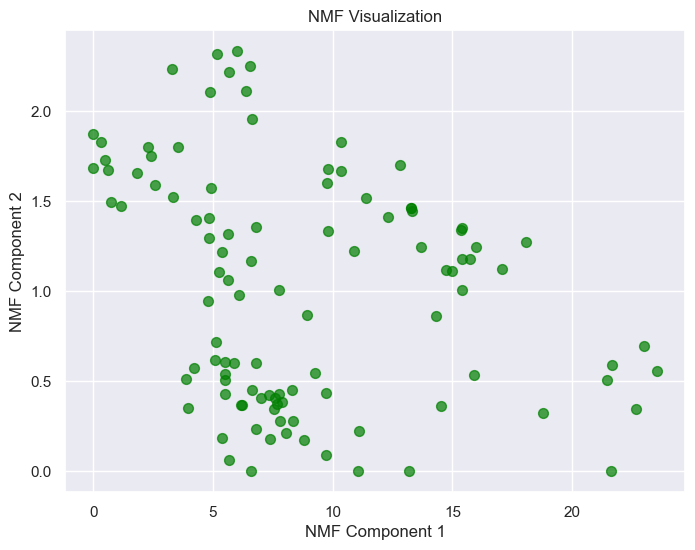

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(nmf_df['NMF1'], nmf_df['NMF2'], c='green', s=50, alpha=0.7)
plt.title('NMF Visualization')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.show()

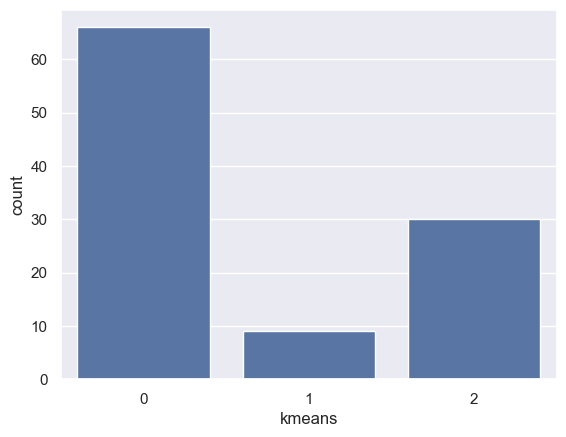

In [61]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(nmf_df)
labels = kmeans.predict(nmf_df)
nmf_df['kmeans'] = labels
sns.countplot(data=nmf_df, x=nmf_df['kmeans'])
plt.show()

In [62]:
# Compute the linkage matrix
linkage_matrix = linkage(nmf_df, method='ward')

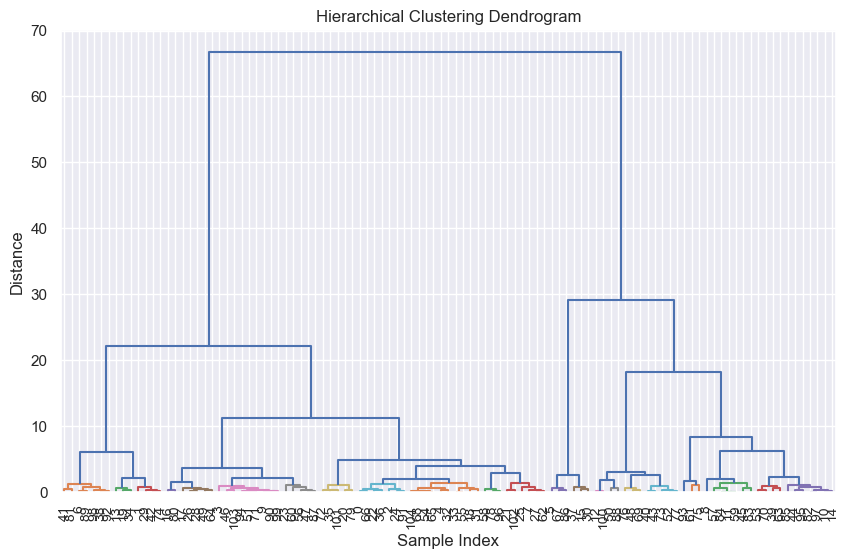

In [63]:
plot_dendrogram(linkage_matrix)

In [64]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
nmf_df['HC'] = cluster_labels
print(nmf_df)

          NMF1      NMF2  kmeans  HC
0     5.252742  1.106212       0   1
1     1.844051  1.657714       0   1
2     4.784101  0.944627       0   1
3     7.735443  1.007984       0   1
4     5.685859  0.063564       0   1
..         ...       ...     ...  ..
100  11.097284  0.221186       2   3
101   6.373961  2.110852       0   1
102   5.161127  2.317322       0   1
103   7.396008  0.176942       0   1
104   5.503155  0.431114       0   1

[105 rows x 4 columns]


In [65]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(nmf_df)

# Add t-SNE results to the DataFrame
nmf_df['t-SNE1'] = tsne_results[:, 0]
nmf_df['t-SNE2'] = tsne_results[:, 1]

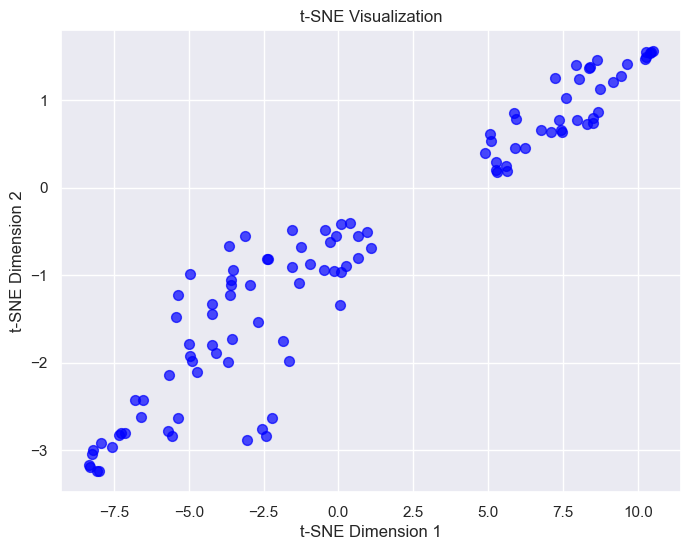

In [66]:
plot_tsne(nmf_df, x='t-SNE1', y='t-SNE2')

## Results

## Conclusion & Advice

## Sources